**сеть Кохонена (SOM, самоорганизующиеся карты Кохонена)**

решение задачи кластеризации

_Евгений Борисов <esborisov@sevsu.ru>_

---

Kohonen, T. Learning Vector Quantization, Neural Networks, 1988, 1 (suppl 1), 303.

Kohonen, T.  The Self-Organizing Map.   
https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf

Горбаченко В.И.  Сeти Кохонена.  
https://masters.donntu.org/2018/fknt/shumskyi/library/article8.pdf

Нестандартная кластеризация 4: Self-Organizing Maps, тонкости, улучшения, сравнение с t-SNE.    
https://habr.com/ru/post/338868/

Борисов Е.С.  Кластеризатор на основе нейронной сети Кохонена.   
http://mechanoid.su/neural-net-kohonen-clusterization.html

---

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# np.set_printoptions(precision=3,suppress=True)

---

In [2]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

## данные

In [3]:
from sklearn.datasets import make_blobs

n_samples = 500
n_clusters = 17 # количество кластеров
n_features = 3

X,_ = make_blobs( 
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,  
        cluster_std=rng.uniform(size=n_clusters)+.7
    )
X.shape

(500, 3)

In [4]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X)

del X

In [5]:
# fig = plt.figure(figsize=(14,14))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(xs=X_train[:,0], ys=X_train[:,1], zs=X_train[:,2],) 

## модель

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

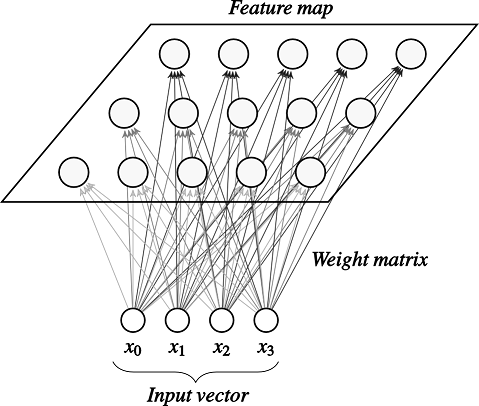

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

соединения нейронов выходного слоя могут иметь разную топологию, (это не обязательно двумерная решетка)

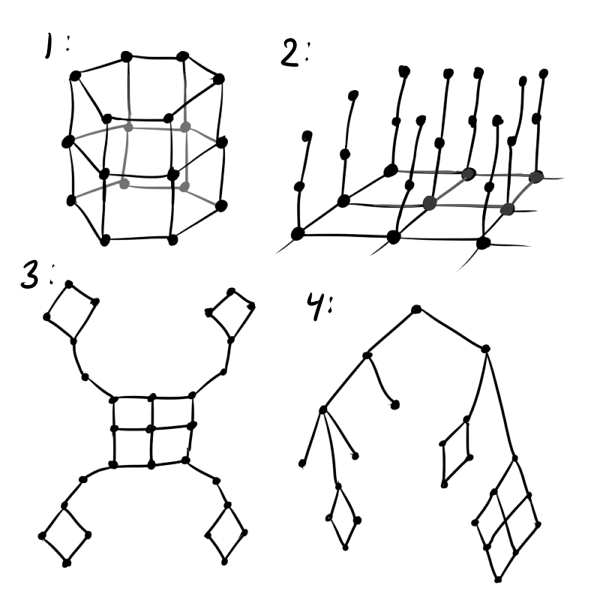

https://habr.com/ru/post/338868/


SOM решает задачу векторного квантования,   
которая состоит в наилучшей аппроксимации всей совокупности векторов данных $X$    
ограниченным набором кодовых векторов $W$.

состояние нейрона
$$s = \|x,w\| $$

In [6]:
# евклидово расстояние 

from sklearn.metrics.pairwise import euclidean_distances

def state(x,w): # состояние нейронов
    return euclidean_distances(x,w)

def score(x,weight): 
    s = state(x,weight)
    return np.argmin(s, axis=1), s

def predict(x,weight): 
    return np.argmin( state(x,weight), axis=1)

### инициализация параметров сети

In [7]:
# инициализация параметров сети

n_features = X_train.shape[1] # размерность простраства признаков

# топология выходного слоя - двумерная решетка
grid_size=(5,7) # размер решетки (количество нейронов)

# параметры признаков
lim = np.vstack([ X_train.min(axis=0), X_train.max(axis=0), X_train.mean(axis=0) ])

# накрываем данные сеткой (строим гиперплоскость)
weight = np.meshgrid(
        np.linspace(*lim[:2,0],grid_size[0]),
        np.linspace(*lim[:2,1],grid_size[1]),
    )

weight = np.stack([
            weight[0].T,
            weight[1].T,
        ] + [ np.ones(grid_size)*lim[2,i] for i in range(n_features-2)]
    ).transpose(1,2,0)


weight = weight.reshape( np.prod(grid_size),n_features )

weight.shape

(35, 3)

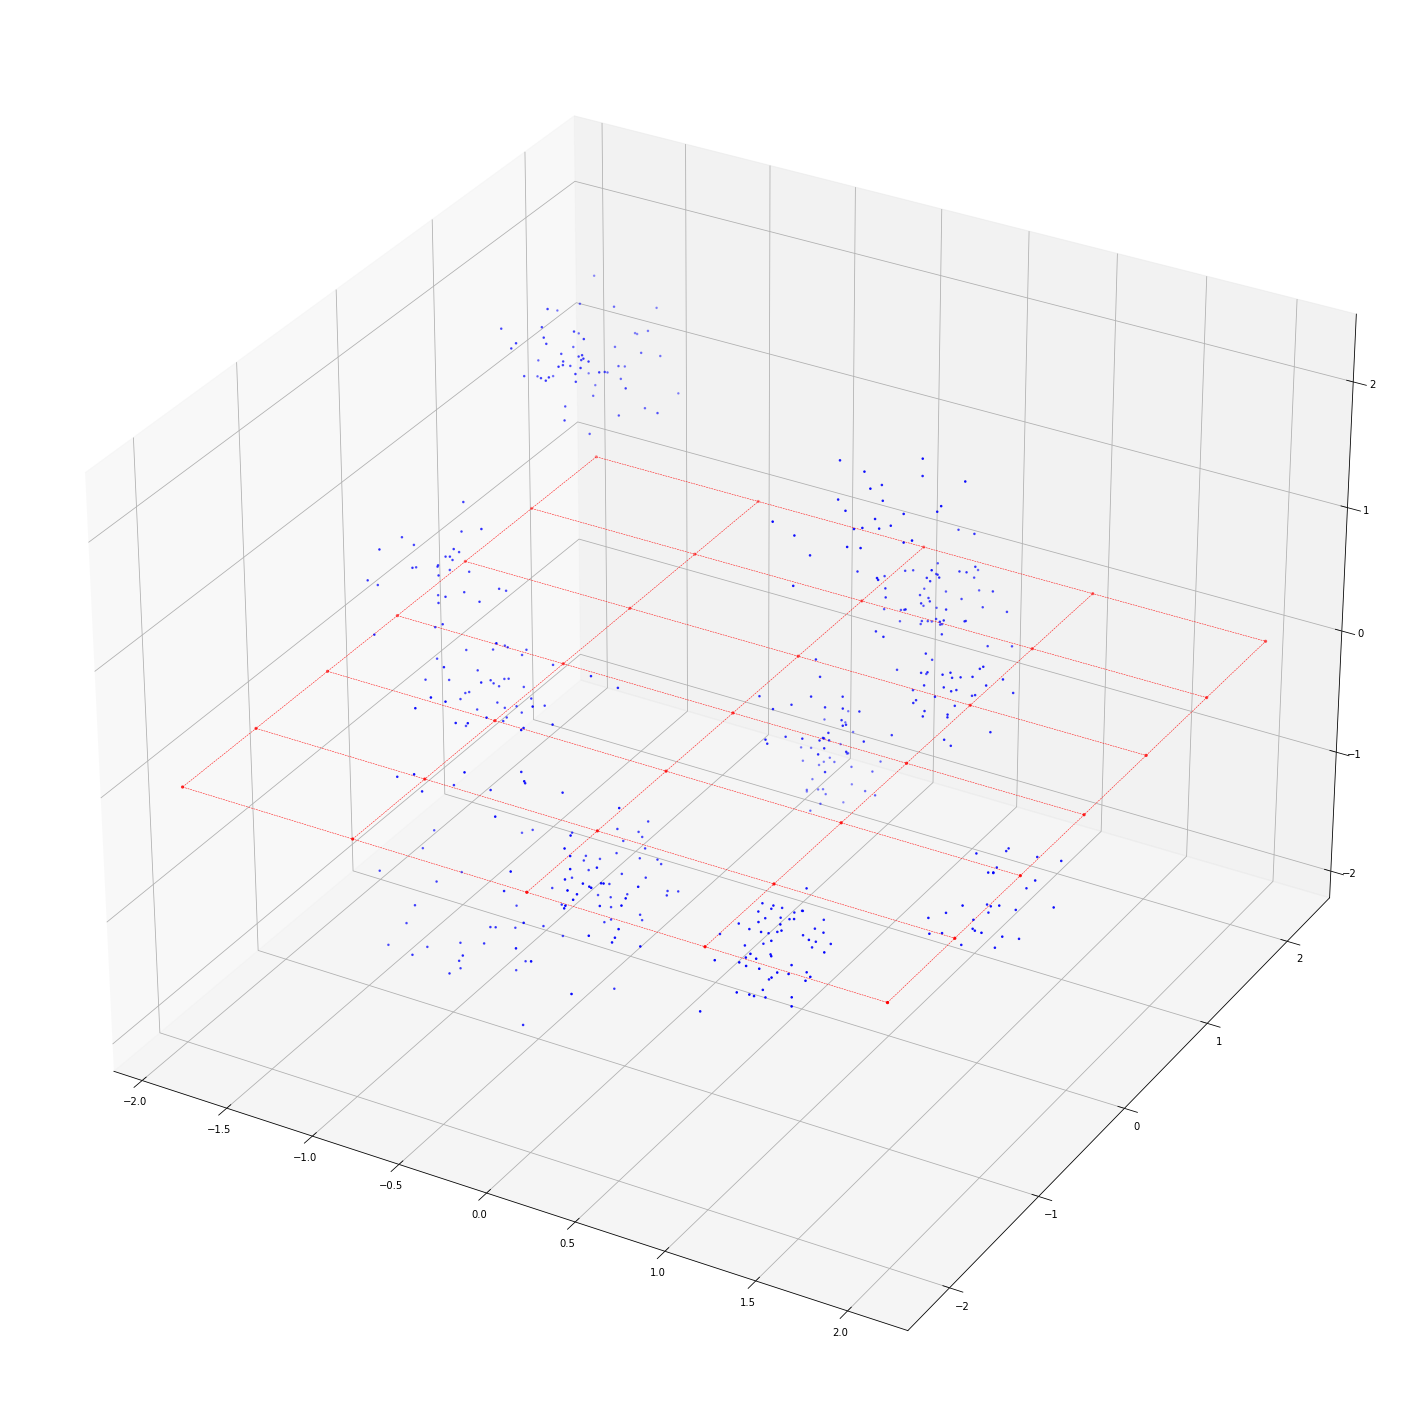

In [8]:
def plot_map_3d(weight,grid_size,ax):    
    r,c = grid_size
    w = weight.reshape(grid_size+(3,))
    
    for j in range(c): 
        ax.plot(
                w[:,j,0].flatten(),
                w[:,j,1].flatten(),
                w[:,j,2].flatten(),
                color='r',
                linestyle='dashed',
                linewidth=.5
            )
    
    for i in range(r): 
        ax.plot(
                w[i,:,0].flatten(),
                w[i,:,1].flatten(),
                w[i,:,2].flatten(),
                color='r',
                linestyle='dashed',
                linewidth=.5
            )
    ax.scatter(xs=weight[:,0],ys=weight[:,1],zs=weight[:,2],marker='.',color='r',s=20)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0],X_train[:,1],X_train[:,2],s=10,marker='.',color='b')
plot_map_3d(weight,grid_size,ax)  


## обучение

### функция окрестности

In [9]:
def gauss(d,s=.1): # функция окрестности
    return np.exp(-np.square(d)/s)

Text(0.5, 1.0, 'функция окрестности')

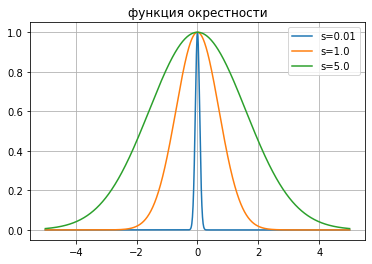

In [10]:
d = np.linspace(-5,5,1000)
plt.plot(d,gauss(d,s=.01),label='s=0.01')
plt.plot(d,gauss(d,s=1.),label='s=1.0')
plt.plot(d,gauss(d,s=5.),label='s=5.0')
plt.grid()
plt.legend()
plt.title('функция окрестности')

In [11]:
# место (i,j) нейрона n в двумерной решетке
def number2indices(n,grid_size):
    return np.vstack([ np.unravel_index(i,grid_size) for i in n ])

# расстояние между нейронами n1 и n2 в двумерной решетке
def distance_on_map(n1,n2,grid_size):
    i1 = number2indices(n=n1,grid_size=grid_size)
    i2 = number2indices(n=n2,grid_size=grid_size)
    return np.abs( i1[:,np.newaxis,:] - i2[np.newaxis, :, :] ).max(axis=-1)

# векторы расстояний от ка ждого нейрона до всех остальных нейронов двумерной решетки
def distance_on_map_all(grid_size):
    n = list(range(np.prod(grid_size)))
    return distance_on_map(n,n,grid_size)

# grid_distance = distance_on_map_all(grid_size)

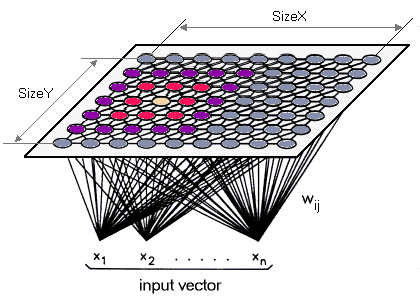

In [12]:
# коэффициенты окрестности для нейронов номер [n1,n2,...]
def neighbor_score(n,sig,grid_distance):
    return gauss( grid_distance[n,:], s=sig )

# neighbor_score([1,2,3],sig=.5)

### изменение весов

_competitive hebbian learning_  

изменение весов

$$
\Delta w = \eta\cdot \theta(k) \cdot (x − w)
$$


$\eta \in (0,1)$ - шаг обучения   

$k$ - номер нейрона-победителя

$\theta(k)_{j} \in [0,1]$ - значение ф-ции окрестности нейрона-победителя $k$ для нейрона $j$;


In [13]:
def get_batch(x,batch_size):
    n_samples = len(x) # количество учебных пар
    batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
    # перемешиваем учебный набор и режем его на батчи
    for idx in np.array_split(rng.permutation(n_samples), batch_count ):
        yield x[idx,:]

In [14]:
def fit_batch(x,weight,lr,sig,grid_distance):
    # определяем выходной нейрон-победитель
    winner,s = score(x,weight) 

    # значение функции окрестности нейрона-победителя для всех выходных нейронов
    nb = neighbor_score(winner,sig=sig,grid_distance=grid_distance)  

    # изменение весов
    dw = ( ( x[:,np.newaxis,:] - weight[np.newaxis,:,:] ) * nb[:,:,np.newaxis] ).mean(axis=0)
    
    return weight + lr*dw

In [15]:
def fit_epoch(x,weight,lr,sig,grid_distance,batch_size): # эпоха обучения
    weight_ = weight.copy()
    for xb in get_batch(x,batch_size): # для всех точек учебного датасета
        weight_ = fit_batch( xb, weight_, lr, sig, grid_distance) # подстраиваем веса
    return weight_

In [16]:
def msqe(a,b): # среднее квадратичное отклонение
    return np.square(a-b).mean()

In [17]:
def input_variance(x,weight): # среднее отклонение входа от вектора весов победителя
    win = predict(x,weight)
    return np.mean([ msqe(weight[c], x[win==c]) for c in set(win) ])

В начале процедуры настройки всем нейронам конкурирующего слоя присваивается одинаковый параметр активности

In [18]:
# grid_size = (101,101) # размеры решетки выходного слоя
# weight = weight_init(input_size=X_train.shape[1],output_size=grid_size)
weight0 = weight.copy()

In [19]:
# np.linspace(grid_size)

In [20]:
lr = .5 # скорость обучения
lr_step = .99 # шаг уменьшения скорости обучения
lr_min = .09 # минимальная скорость обучения

# параметр размера окрестности для нейрона-победителя
sig = np.sqrt(len(weight)).astype(int) 
sig_step = .85 # шаг уменьшения размера окрестности
sig_min = .01 # минимальное значение параметра размера окрестности

dw_history = [] # история отклонения весов
inp_var_history = [] # история изменения среднего отклонения входа от вектора весов победителя
lr_history = [] # история изменения скорости обучения
sig_history = [] # история изменения размера окрестности для нейрона-победителя

weight_var_min = 9e-6 # минимально существенное отклонение весов

# размер одного пакета учебных данных
#batch_size = len(X_train)//10 
batch_size = 5

# векторы расстояний от каждого нейрона до всех остальных нейронов двумерной решетки
grid_distance = distance_on_map_all(grid_size)

In [21]:
from tqdm import tqdm

In [22]:
%%time 

n_epoch = 200 # количество циклов обучения


epoch = tqdm(range(n_epoch))
for i in epoch:
    w = weight.copy() # сохраняем старые значения весов
    
    # шаг обучения модели
    weight = fit_epoch(X_train,weight,lr,sig,grid_distance,batch_size) 
       
    dw_history.append(msqe(weight,w)) # считаем отклонение весов
    
    inp_var_history.append( input_variance(X_train,weight) )
    
    epoch.set_postfix({'weight var':dw_history[-1],'inp var':inp_var_history[-1],'lr':lr,'sig':sig,})
    lr= max(lr*lr_step,lr_min) # уменьшаем скорость обучения
    sig = max(sig*sig_step,sig_min) # уменьшаем размер окрестности нейрона-победителя

    lr_history.append(lr) # история изменения скорости обучения
    sig_history.append(sig) # история изменения размера окрестности для нейрона-победителя
    
#     if dw_history[-1]<weight_var_min: # если нет существенного изменения весов...
#         print('low weight variance detected')
#         break # ... то выходим
        
#     if var_history[-1]<var_min:
#         print('low variance detected')
#         break

100%|██████████| 200/200 [00:13<00:00, 14.78it/s, weight var=1.22e-6, inp var=0.0255, lr=0.09, sig=0.01]   

CPU times: user 12.4 s, sys: 574 ms, total: 13 s
Wall time: 13.6 s


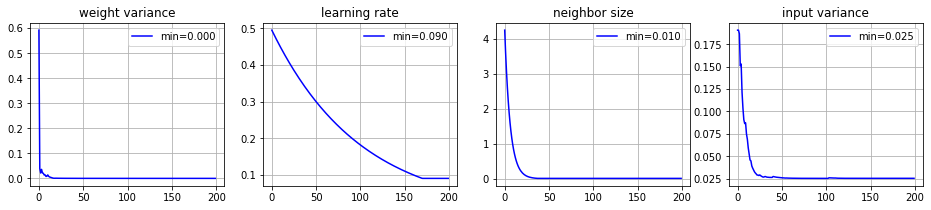

In [23]:
history = {
'weight variance':dw_history,
'learning rate':lr_history,
'neighbor size':sig_history,
'input variance': inp_var_history,
}

fig,ax = plt.subplots(1,len(history),figsize=(16,3))
for i,t in enumerate(history):
    ax[i].plot(history[t],c='b',label='min=%.3f'%min(history[t]))
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(t)

## тестируем

In [24]:
p = predict(X_train,weight)

In [25]:
print( 'clusters:', len(set(p)) )

clusters: 33


In [26]:
from scipy.spatial import ConvexHull

def plot3d(X,p,clusters,colors,ax):
    for c in clusters: 
        ax.scatter( xs=X[p==c,0], ys=X[p==c,1], zs=X[p==c,2], c=[ colors[ clusters[c] ] ] )    
        
def plot(X,p,weight,grid_size,figsize=(10,10)):
    clusters = { c:i for i,c in enumerate(sorted(set(p)))}
    colors = rng.uniform(size=(len(clusters),3),low=.0,high=1.)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
#     plot3d(X,p,clusters,colors,ax)
    ax.scatter( xs=X[:,0], ys=X[:,1], zs=X[:,2], c='b',s=10)
    
    plot_map_3d(weight,grid_size,ax)        

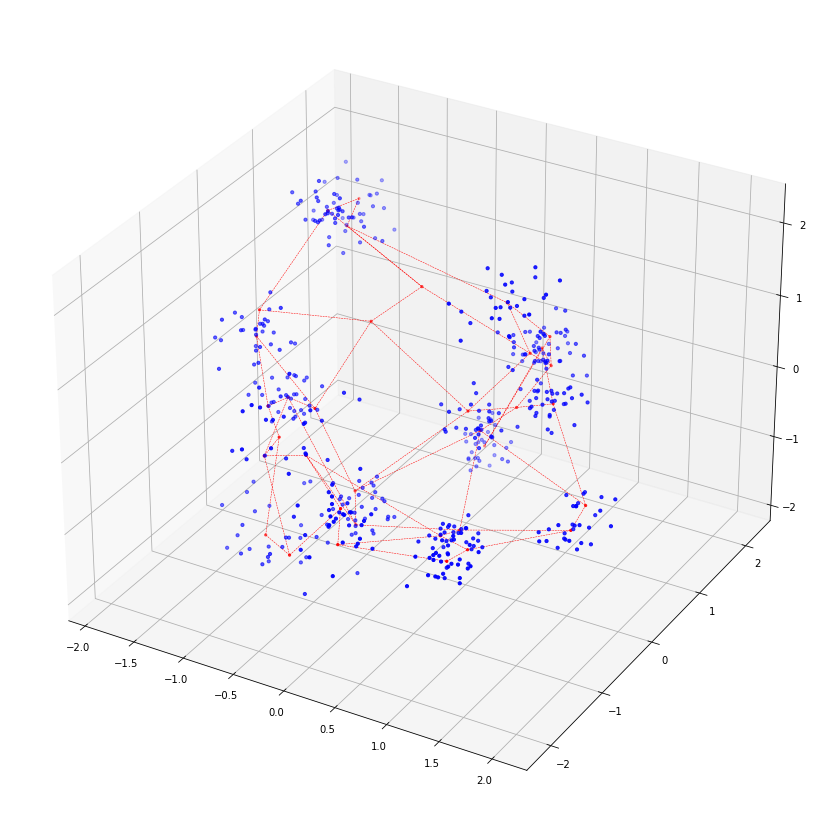

In [27]:
plot(X_train,p,weight,grid_size,figsize=(15,15))

In [28]:
# оценка результата
from sklearn.metrics import silhouette_score

# clusters = { c:i for i,c in enumerate(sorted(set(p)))}
# c = np.vectorize(lambda c:clusters[c])(p)

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X_train,p)

0.3906783525312064

In [29]:
def arr2img(x):
    x_min,x_max = x.min(),x.max()
    d = (x_max-x_min)
    d = d if d>0. else 1.
    return np.floor(((x-x_min)/d)*254).astype(np.int)   

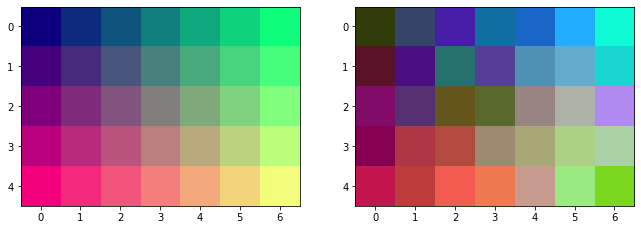

In [30]:
n_feature = X_train.shape[1]


im0 = weight0.reshape(grid_size+(3,))
im1 = weight.reshape(grid_size+(3,))
cmap='rainbow'
    
fig,ax = plt.subplots(1,2,figsize=(11,5))
ax[0].imshow( arr2img( im0), cmap=cmap )
ax[1].imshow( arr2img( im1), cmap=cmap )